In [2]:
########## Imports ##########
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import time
import pickle
import os
import datetime

import packages.fonctions as fonctions
from packages import cost

#Preprocessing, Upsampling, Model Selection, Model Evaluation
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score 
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, cross_validate
from sklearn.feature_selection import RFECV
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline

# Modèles
#!pip install catboost
#!brew install cmake libomp
#!pip install lightgbm
from sklearn.dummy import DummyClassifier # modèle baseline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Warnings
import warnings
warnings.simplefilter(action = 'ignore')

# MLFLOW
#!pip install mlflow
import mlflow
from mlflow.models import infer_signature
import logging

# Set display preferences
pd.set_option('display.max_row', 250)
pd.set_option('display.max_column', 200)

In [3]:
########## Import des données ##########

path = '' #-> en local
filepath = os.path.join(path, 'data/df_train')

with open(filepath, 'rb') as f:
    df = pickle.load(f)

df.head()

CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
SK_ID_CURR                                                            
100002               0.0          0.001512    0.090287     0.103342   
100003               0.0          0.002089    0.311736     0.152575   
100004               0.0          0.000358    0.022472     0.022985   
100006               0.0          0.000935    0.066837     0.125662   
100007               0.0          0.000819    0.116854     0.090651   

            AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
SK_ID_CURR                                                            
100002             0.077441                    0.256321    0.111337   
100003             0.271605                    0.045016    0.523713   
100004             0.023569                    0.134897    0.652495   
100006             0.063973                    0.107023    0.650181   
100007             0.117845                    0.392880    0.702518   

            DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
SK_ID_CURR                                                                   
100002           0.964437           0.852140         0.705433     0.098901   
100003           0.933676           0.951929         0.959566     0.098901   
100004           0.987439           0.827335         0.648326     0.285714   
100006           0.830337           0.601451         0.661387     0.098901   
100007           0.830393           0.825268         0.519522     0.098901   

            FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
SK_ID_CURR                                                                  
100002             0.0             1.0              0.0               1.0   
100003             0.0             1.0              0.0               1.0   
100004             0.0             1.0              1.0               1.0   
100006             0.0             1.0              0.0               1.0   
100007             0.0             1.0              0.0               1.0   

            FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
SK_ID_CURR                                                                  
100002             1.0         0.0         0.000000                   0.5   
100003             1.0         0.0         0.052632                   0.0   
100004             1.0         0.0         0.000000                   0.5   
100006             0.0         0.0         0.052632                   0.5   
100007             0.0         0.0         0.000000                   0.5   

            REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
SK_ID_CURR                                                         
100002                              0.5                 0.434783   
100003                              0.0                 0.478261   
100004                              0.5                 0.391304   
100006                              0.5                 0.739130   
100007                              0.5                 0.478261   

            REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
SK_ID_CURR                                                           
100002                             0.0                         0.0   
100003                             0.0                         0.0   
100004                             0.0                         0.0   
100006                             0.0                         0.0   
100007                             0.0                         0.0   

            LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
SK_ID_CURR                                                        
100002                              0.0                     0.0   
100003                              0.0                     0.0   
100004                              0.0                     0.0   
100006                              0.0                     0.0   
100007             

In [4]:
filepath = os.path.join(path, 'data/target')

with open(filepath, 'rb') as f:
    df_target = pickle.load(f)

df_target.head()

SK_ID_CURR
100002    1
100003    0
100004    0
100006    0
100007    0
Name: TARGET, dtype: int64

In [5]:
# Séparation en train et en test

X = df
y = df_target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [6]:
# on remet la target dans les données ?
#X_train['TARGET'] = y_train
#X_test['TARGET'] = y_test

In [7]:
print('train shape :', X_train.shape)
print('test shape :', X_test.shape)

train shape : (232842, 175)
test shape : (58211, 175)


In [8]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((232842, 175), (58211, 175), (232842,), (58211,))

In [8]:
# ici :
# -> données avec labels -> Supervised Learning
# -> 0/1 (variable discrète) -> Classification

In [9]:
# ML FLOW

# -> partie à comprendre

"""

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri = "http://127.0.0.1:8080")

# Create a new MLflow Experiment
mlflow.set_experiment("MLflow Quickstart")

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the loss metric
    mlflow.log_metric("accuracy", accuracy)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "Basic LR model for iris data")

    # Infer the model signature
    signature = infer_signature(X_train, lr.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model = lr,
        artifact_path = "iris_model",
        signature = signature,
        input_example = X_train,
        registered_model_name = "tracking-quickstart",
    )

    """




#logging.basicConfig(level = logging.WARN)
#logger = logging.getLogger(__name__)

mlflow.set_tracking_uri(uri = "http://127.0.0.1:8080")
#mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment(experiment_name = 'scoring')

<Experiment: artifact_location='mlflow-artifacts:/758371766557830604', creation_time=1714046714905, experiment_id='758371766557830604', last_update_time=1714046714905, lifecycle_stage='active', name='scoring', tags={}>

### Fonction de coût

In [10]:
######### Analyse des erreurs de prédiction ########

# - FP (False Positive) :
# = quand la prédiction est positive, mais la valeur réelle est négative
# va induire une perte réelle si le crédit client accepté se transforme en défaut de paiement. -> PENALITE DE 10

# - FN (False Negative) :
# = quand la prédiction est négative, mais la valeur réelle est positive
# va induire une perte d'opportunité si le crédit client est refusé à tort, alors qu'il aurait été en mesure d'être remboursé. -> PENALITE DE 1

# les pertes d'un crédit en raison d'une mauvaise classification dépendront des probabilités Faux Positifs et Faux Négatifs.

# L'idée est d'éviter les clients avec un fort risque de défaut. Il est donc nécessaire de pénaliser les FP et FN.
# On part du F-Score, mesure de la performance d'un modèle de classification qui combine les mesures de précision et de rappel, elles mêmes basées sur les taux de vrais positifs, faux positifs et faux négatifs
# (donc va être idéal à adapter dans notre cas)

# cf cost.py

### Modèle Baseline

In [11]:
# Modèle baseline = DummyClassifier
# https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html

# sert de base pour comparer avec des modèles plus complexes
# fait des prédictions en ignorant les input features

In [10]:
# Régression Logistique
dc = DummyClassifier()
dc.fit(X_train, y_train)

roc_auc = roc_auc_score(y_test, dc.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, dc.predict(X_test)))

AUC : 0.5000
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     53329
           1       0.00      0.00      0.00      4882

    accuracy                           0.92     58211
   macro avg       0.46      0.50      0.48     58211
weighted avg       0.84      0.92      0.88     58211



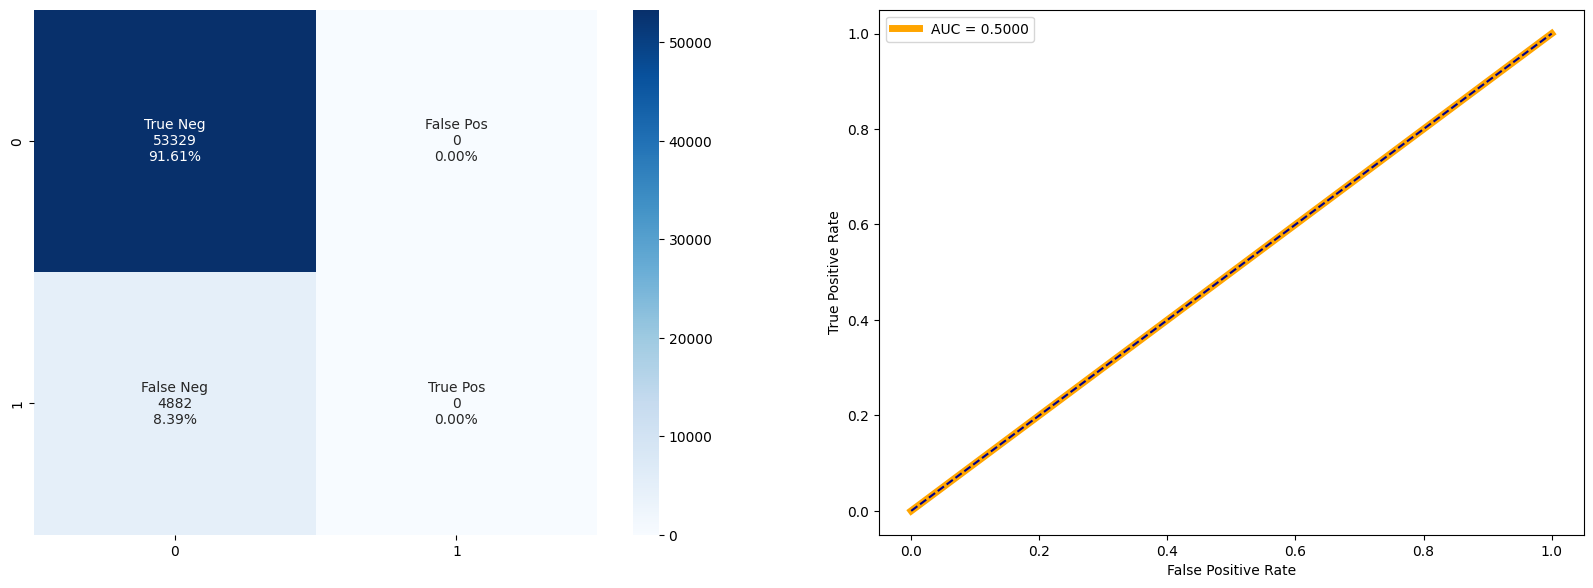

In [11]:
fonctions.cf_matrix_roc_auc(dc, y_test, dc.predict(X_test), dc.predict_proba(X_test)[:,1], roc_auc)

In [12]:
cost.custom_metric(y_test, dc.predict(X_test))

4509

In [13]:
####### déséquilibre des classes

# 2 options :
# - undersampling : Parmi les individus majoritaires, on en retire une partie afin d’accorder plus d’importance aux individus minoritaires
# - oversampling : Le nombre d’individus minoritaires est augmenté pour qu’ils aient plus d’importance lors de la modélisation

# pour l'oversampling : différentes solutions sont possibles, comme le “clonage” aléatoire ou le SMOTE

In [14]:
# SMOTE
# = Synthetic Minority Oversampling TEchnique
# = méthode de suréchantillonnage des observations minoritaires

# https://kobia.fr/imbalanced-data-smote/

# https://stackoverflow.com/questions/50245684/using-smote-with-gridsearchcv-in-scikit-learn

In [15]:
# PASSER PAR LE PIPELINE IMBLEARN
# si AUC gridsearch dépasse 0,82 -> overfit

# regarder quels modèles peuvent intégrer les class weight

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [17]:
# smote -> faire le split avant le smote (on veut pouvoir valider sur des vraies données - on veut que le modèle ait bon sur de vraies données)
# https://www.kaggle.com/discussions/questions-and-answers/427399
# sinon risque de data leakage

In [18]:
# Définition de l'instance SMOTE
sm = SMOTE(
    k_neighbors = 3, # nombre de plus proches voisins
    sampling_strategy = 0.75, # taux d'observations minoritaires à atteindre - 0,75 -> après smote minoritaire devient majoritaire ? 
    random_state = 0
    )

# Application du SMOTE aux données
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

In [19]:
# Régression Logistique
dc_smote = DummyClassifier()
dc_smote.fit(X_train_smote, y_train_smote)

roc_auc = roc_auc_score(y_test, dc_smote.predict_proba(X_test)[:, 1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, dc_smote.predict(X_test)))

AUC : 0.5000
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     53329
           1       0.00      0.00      0.00      4882

    accuracy                           0.92     58211
   macro avg       0.46      0.50      0.48     58211
weighted avg       0.84      0.92      0.88     58211



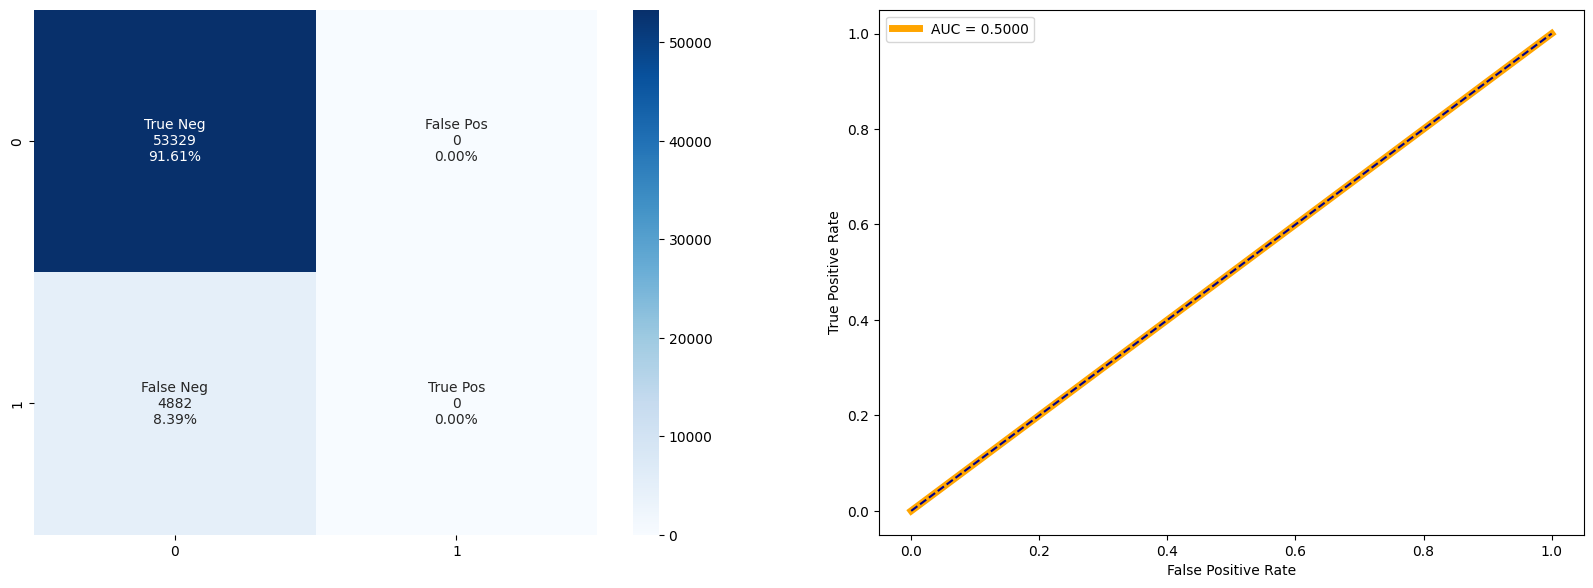

In [20]:
fonctions.cf_matrix_roc_auc(dc_smote, y_test, dc_smote.predict(X_test), dc_smote.predict_proba(X_test)[:, 1], roc_auc)

In [21]:
cost.custom_metric(y_test, dc.predict(X_test))

4509

In [22]:
###### Tuning SMOTE ###########

# Compute custom_metric according to K
k_value = []
custom = []

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

for i in range(2, 20):
    sm = SMOTE(
        k_neighbors = i, # nombre de plus proches voisins
        sampling_strategy = 0.75, # taux d'observations minoritaires à atteindre - 0,75 -> après smote minoritaire devient majoritaire ? 
        random_state = 0
        )

    X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)
    
    k_value.append(i)
    dc = DummyClassifier()
    dc.fit(X_train_smote, y_train_smote)
    cout = cost.custom_metric(y_test, dc.predict(X_test))
    custom.append(cout)

custom

[4509,
 4509,
 4509,
 4509,
 4509,
 4509,
 4509,
 4509,
 4509,
 4509,
 4509,
 4509,
 4509,
 4509,
 4509,
 4509,
 4509,
 4509]

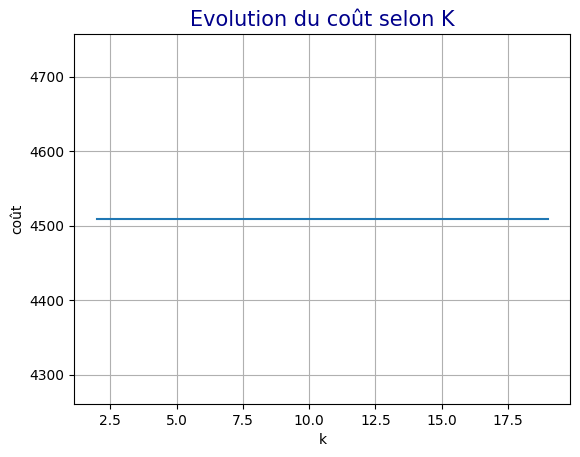

In [23]:
plt.figure()
plt.grid()
plt.plot(k_value, custom)
plt.title ("Evolution du coût selon K", fontsize = 15, color = 'darkblue')
plt.xlabel('k')
plt.ylabel('coût')
plt.show()

In [24]:
# Compute custom_metric according to K
sampling_value = []
custom = []

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

for i in [0.1, 0.2, 0.3, 0.4, 0.5, 0.75]:
    sm = SMOTE(
        k_neighbors = 3, # nombre de plus proches voisins
        sampling_strategy = i, # taux d'observations minoritaires à atteindre - 0,75 -> après smote minoritaire devient majoritaire ?
        random_state = 0
        )

    X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

    sampling_value.append(i)
    dc = DummyClassifier()
    dc.fit(X_train_smote, y_train_smote)
    cout = cost.custom_metric(y_test, dc.predict(X_test))
    custom.append(cout)

custom

[4509, 4509, 4509, 4509, 4509, 4509]

In [25]:
# prendre 0.5 ou minority ou all

In [26]:
# MLFLOW

# Define the model hyperparameters
params = {
    "strategy": "most_frequent"
}

# Train the model
dc = DummyClassifier(**params)
dc.fit(X_train, y_train)

# Predict on the test set
y_pred = dc.predict(X_test)

# Calculate metrics
custom = cost.custom_metric(y_test, y_pred)

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri = 'http://127.0.0.1:8080')

# Create a new MLflow Experiment
mlflow.set_experiment('Scoring')

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the loss metric
    mlflow.log_metric('custom', custom)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag('Training Info', 'Basic baseline model for loan data')

    # Infer the model signature
    signature = infer_signature(X_train, dc.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model = dc,
        artifact_path = 'projet7',
        signature = signature,
        input_example = X_train,
        registered_model_name = 'tracking-quickstart',
    )

Registered model 'tracking-quickstart' already exists. Creating a new version of this model...
2024/04/30 13:10:09 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: tracking-quickstart, version 5
Created version '5' of model 'tracking-quickstart'.


### Regression logistique

In [27]:
### Logistic Regression

# Le projet consiste à mieux comprendre le défaut de crédit rencontré chez certain client, l'anticiper, l'estimer, etc…
# La prédiction peut se résumer par une sortie binaire, une acceptation de crédit, ou un refus de crédit.
# Afin d'avoir une première idée des performances possibles, la modélisation par régression logistique permettra d'obtenir une baseline.

In [28]:
# Régression Logistique
lr = LogisticRegression()
lr.fit(X_train, y_train)

roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, lr.predict(X_test)))

AUC : 0.7433
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     53329
           1       0.53      0.01      0.03      4882

    accuracy                           0.92     58211
   macro avg       0.72      0.51      0.49     58211
weighted avg       0.88      0.92      0.88     58211



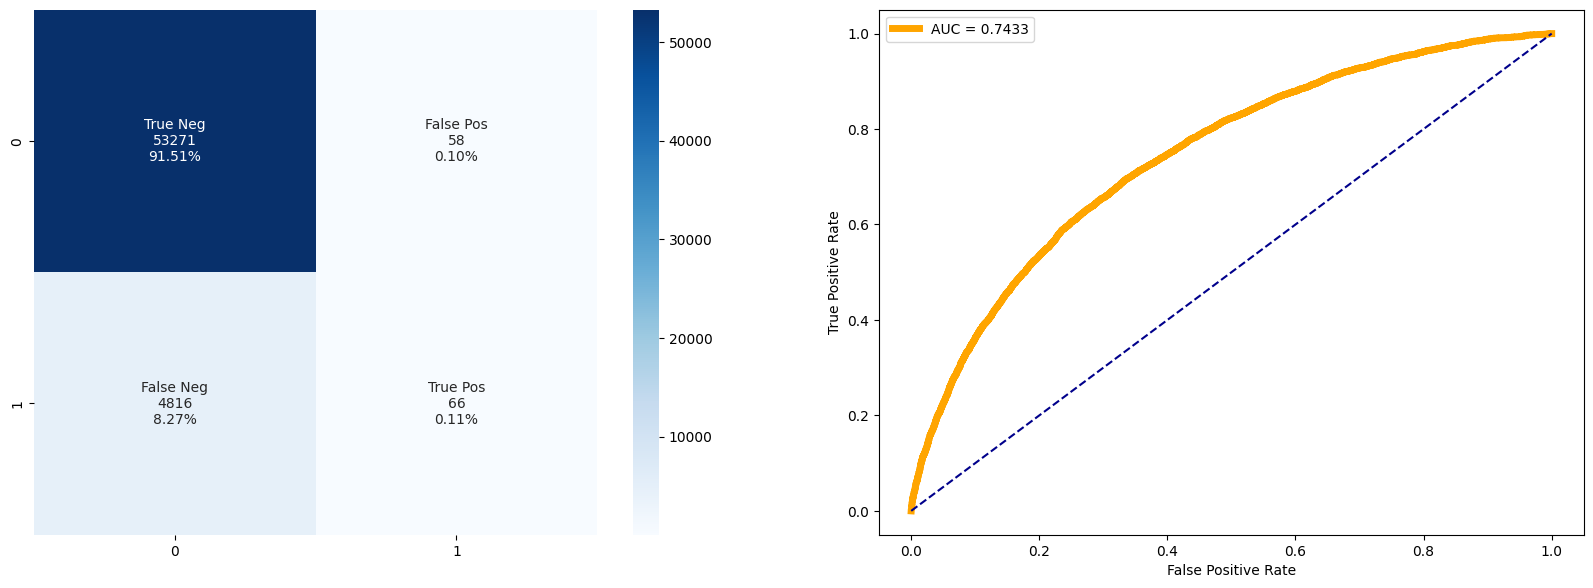

In [29]:
fonctions.cf_matrix_roc_auc(lr, y_test, lr.predict(X_test), lr.predict_proba(X_test)[:,1], roc_auc)

In [30]:
cost.custom_metric(y_test, lr.predict(X_test))

5103

In [31]:
# AUC = Area Under the Curve ROC
# courbe ROC : Recall in y-axis and 1-Specificity in x-axis

# -> indicates how well the probabilities from the positive classes are separated from the negative classes
# 0,5 -> 50%/50% -> le marqueur est non informatif
# entre 0,5 et 1,0 -> discrimination

In [32]:
# smote

In [33]:
# Définition de l'instance SMOTE
sm = SMOTE(
    k_neighbors = 3, # nombre de plus proches voisins
    sampling_strategy = 0.75, # taux d'observations minoritaires à atteindre - 0,75 -> après smote minoritaire devient majoritaire ? 
    random_state = 0
    )

# Application du SMOTE aux données
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

In [34]:
# on remet la target dans les données ?
#X_train_smote['TARGET'] = y_train_smote
#X_test_smote['TARGET'] = y_test_smote

In [35]:
# Régression Logistique
lr_smote = LogisticRegression()
lr_smote.fit(X_train_smote, y_train_smote)

roc_auc_smote = roc_auc_score(y_test, lr_smote.predict_proba(X_test)[:, 1])
print('AUC : %0.4f' %roc_auc_smote)
print(classification_report(y_test, lr_smote.predict(X_test)))

AUC : 0.7415
              precision    recall  f1-score   support

           0       0.95      0.78      0.86     53329
           1       0.19      0.56      0.28      4882

    accuracy                           0.76     58211
   macro avg       0.57      0.67      0.57     58211
weighted avg       0.89      0.76      0.81     58211



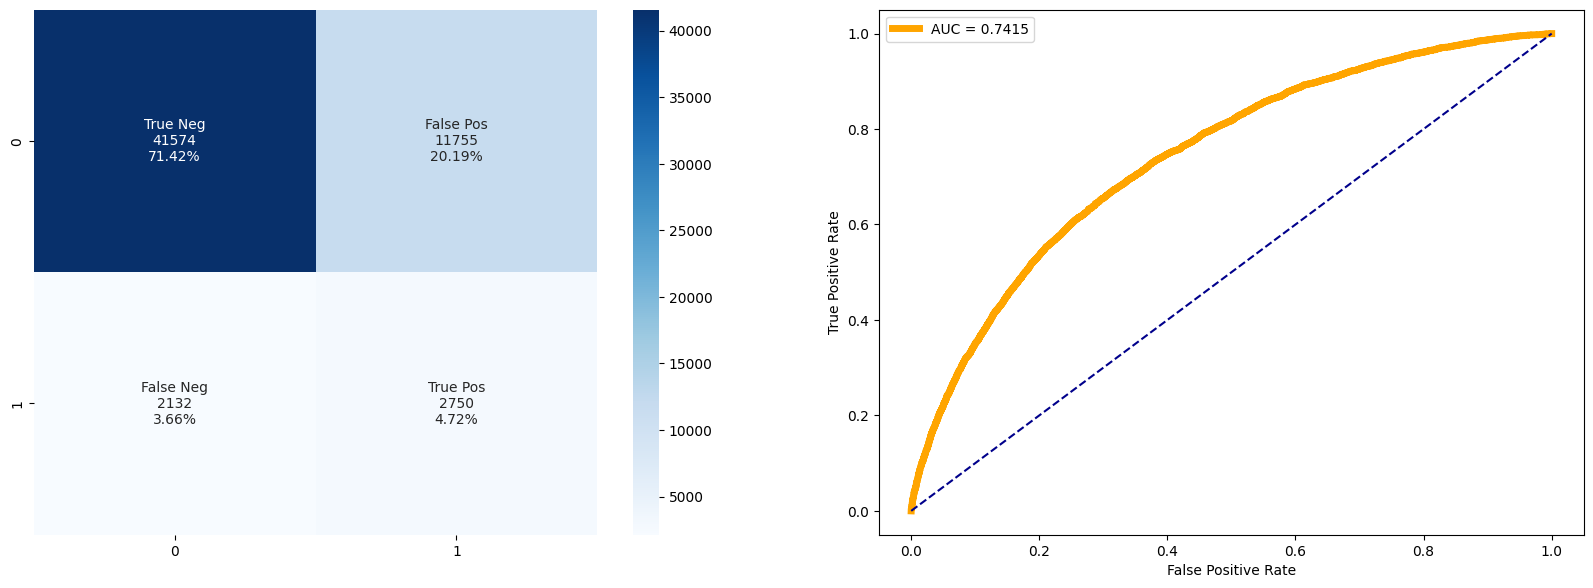

In [36]:
fonctions.cf_matrix_roc_auc(lr_smote, y_test, lr_smote.predict(X_test), lr_smote.predict_proba(X_test)[:, 1], roc_auc_smote)

In [37]:
cost.custom_metric(y_test, lr_smote.predict(X_test))

29259

In [38]:
# mieux ! test avec d'autres modèles et comparaison

### Test de différents modèles

In [39]:
# modèle baseline
# prets attribués de manière aléatoire
# dummy classifier

In [40]:
# ne pas oublier de sauvegarder à chaque fois les résultats dans mlflow
# si je le fais une fois pour toute ça va aussi

In [41]:
models = [
    DummyClassifier(), # modèle baseline
    KNeighborsClassifier(), # k-nearest neighbors
    LogisticRegression(), # Regression logistique
    GaussianNB(), # Naives Bayes
    #SVC(), # -> long !! # Support Vector Machines - beaucoup trop long, exclu d'office
    CatBoostClassifier(logging_level = 'Silent'),
    LGBMClassifier(),
    DecisionTreeClassifier(), # Arbres de decision
    RandomForestClassifier(), # random forest
    AdaBoostClassifier(),
    GradientBoostingClassifier(), # gradient boosting
    XGBClassifier() # XGBoost - erreur sur mac perso mais pas pro
    ]

In [42]:
# SVC() -> test sur échantillon réduit et voir si bonnes perfs

In [43]:
# risque avec smote -> qu'on utilise des données synthétiques dans le jeu de données test quand on cross valide

In [44]:
# Fonction pour calculer les métriques auc, accuracy, f1, precision et recall

def train_models(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    output = {
      'AUC': roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),
      'Accuracy': accuracy_score(y_test, model.predict(X_test)),
      'Precision': precision_score(y_test, model.predict(X_test)),
      'Recall': recall_score(y_test, model.predict(X_test)),
      'F1': f1_score(y_test, model.predict(X_test)),
      'Custom' : cost.custom_metric(y_test, model.predict(X_test))
      }

    return output

In [45]:
# Boucler sur les modèles et évaluer

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
custom = []
time_ = []

for model in models:
    print(type(model).__name__)
    start = time.time()
    results = train_models(model, X_train, X_test, y_train, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    custom.append(results['Custom'])
    time_.append(time.time() - start)

# Initialise data of lists
base_models = pd.DataFrame(data = [name, auc, accuracy, precision, recall, f1, custom, time_]).T
base_models.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Custom', 'Time']
base_models.sort_values('AUC', ascending = False, inplace = True)
base_models.reset_index(drop = True, inplace = True)

DummyClassifier
KNeighborsClassifier
LogisticRegression
GaussianNB
CatBoostClassifier
LGBMClassifier
[LightGBM] [Info] Number of positive: 18963, number of negative: 213879
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27344
[LightGBM] [Info] Number of data points in the train set: 232842, number of used features: 171
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081441 -> initscore=-2.422921
[LightGBM] [Info] Start training from score -2.422921
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
XGBClassifier


In [46]:
base_models

Model       AUC  Accuracy Precision    Recall  \
0           CatBoostClassifier  0.768282   0.91603  0.491713   0.03646   
1               LGBMClassifier  0.763242  0.916356  0.532995  0.021508   
2                XGBClassifier  0.760697  0.915531  0.461707   0.04322   
3   GradientBoostingClassifier  0.754175  0.916201  0.514493  0.014543   
4           AdaBoostClassifier  0.744402  0.916236  0.515306  0.020688   
5           LogisticRegression  0.743299   0.91627  0.532258  0.013519   
6       RandomForestClassifier  0.704734  0.916167       0.6  0.001229   
7                   GaussianNB  0.643198   0.17349  0.087783  0.942851   
8         KNeighborsClassifier  0.584948  0.910429  0.239812   0.03134   
9       DecisionTreeClassifier  0.540044  0.849032  0.148362  0.168783   
10             DummyClassifier       0.5  0.916133       0.0       0.0   

          F1 Custom        Time  
0   0.067887   6111   52.465834  
1   0.041347   5454    8.958917  
2   0.079041   6408   34.622072  
3   0.028287   5148  292.296277  
4   0.039779   5418   56.362172  
5   0.026368   5103    6.027985  
6   0.002453   4563  157.795373  
7   0.160613  45936    0.846615  
8   0.055435   5886  214.080305  
9   0.157915  11925   41.938475  
10       0.0   4509    0.046694

In [47]:
base_models.sort_values(by = 'Custom', ascending = False)

Model       AUC  Accuracy Precision    Recall  \
7                   GaussianNB  0.643198   0.17349  0.087783  0.942851   
9       DecisionTreeClassifier  0.540044  0.849032  0.148362  0.168783   
2                XGBClassifier  0.760697  0.915531  0.461707   0.04322   
0           CatBoostClassifier  0.768282   0.91603  0.491713   0.03646   
8         KNeighborsClassifier  0.584948  0.910429  0.239812   0.03134   
1               LGBMClassifier  0.763242  0.916356  0.532995  0.021508   
4           AdaBoostClassifier  0.744402  0.916236  0.515306  0.020688   
3   GradientBoostingClassifier  0.754175  0.916201  0.514493  0.014543   
5           LogisticRegression  0.743299   0.91627  0.532258  0.013519   
6       RandomForestClassifier  0.704734  0.916167       0.6  0.001229   
10             DummyClassifier       0.5  0.916133       0.0       0.0   

          F1 Custom        Time  
7   0.160613  45936    0.846615  
9   0.157915  11925   41.938475  
2   0.079041   6408   34.622072  
0   0.067887   6111   52.465834  
8   0.055435   5886  214.080305  
1   0.041347   5454    8.958917  
4   0.039779   5418   56.362172  
3   0.028287   5148  292.296277  
5   0.026368   5103    6.027985  
6   0.002453   4563  157.795373  
10       0.0   4509    0.046694

In [48]:
# même chose mais avec mlflow et smote

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
custom = []
time_ = []

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri = 'http://127.0.0.1:8080')
mlflow.set_experiment(experiment_name = 'scoring')

<Experiment: artifact_location='mlflow-artifacts:/758371766557830604', creation_time=1714046714905, experiment_id='758371766557830604', last_update_time=1714046714905, lifecycle_stage='active', name='scoring', tags={}>

In [49]:
# TERMINAL (pour traquer perfs des différents tests avec mlflow)
# Run a local tracking server (optionel)


#mlflow server --host 127.0.0.1 --port 8080

In [50]:
with mlflow.start_run(run_name = 'Test modèles'):
    for model in models:
        print(type(model).__name__)
        start = time.time()
        results = train_models(model, X_train_smote, X_test, y_train_smote, y_test)

        name.append(type(model).__name__)
        auc.append(results['AUC'])
        accuracy.append(results['Accuracy'])
        precision.append(results['Precision'])
        recall.append(results['Recall'])
        f1.append(results['F1'])
        custom.append(results['Custom'])
        time_.append(time.time() - start)

        mlflow.sklearn.log_model(model, 'model')
        mlflow.log_metric('f1 score', results['F1'])
        mlflow.log_metric('custom', results['Custom'])

# Initialise data of lists
base_models = pd.DataFrame(data = [name, auc, accuracy, precision, recall, f1, custom, time_]).T
base_models.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Custom', 'Time']
base_models.sort_values('AUC', ascending = False, inplace = True)
base_models.reset_index(drop = True, inplace = True)

DummyClassifier
KNeighborsClassifier
LogisticRegression
GaussianNB
CatBoostClassifier
LGBMClassifier
[LightGBM] [Info] Number of positive: 160409, number of negative: 213879
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37679
[LightGBM] [Info] Number of data points in the train set: 374288, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.428571 -> initscore=-0.287684
[LightGBM] [Info] Start training from score -0.287684
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
XGBClassifier


In [51]:
base_models

Model       AUC  Accuracy Precision    Recall  \
0           CatBoostClassifier  0.761411  0.916236  0.507895  0.039533   
1               LGBMClassifier  0.747584  0.916236  0.516304  0.019459   
2                XGBClassifier  0.747178  0.914587  0.408163  0.040967   
3           LogisticRegression   0.74145  0.761437   0.18959  0.563294   
4   GradientBoostingClassifier  0.697146  0.915428  0.387978  0.014543   
5       RandomForestClassifier  0.688797  0.915068  0.293333  0.009013   
6           AdaBoostClassifier   0.67214  0.884111  0.201282  0.128636   
7         KNeighborsClassifier  0.603787  0.661473  0.118332  0.470709   
8                   GaussianNB  0.551914  0.220079  0.088984  0.898402   
9       DecisionTreeClassifier     0.536  0.834121  0.133333  0.177796   
10             DummyClassifier       0.5  0.916133       0.0       0.0   

          F1 Custom        Time  
0   0.073356   6246   68.753754  
1   0.037505   5364    7.630823  
2    0.07446   6309   77.664129  
3   0.283695  29259    9.177757  
4   0.028036   5148  658.444351  
5   0.017488   4905  211.006691  
6   0.156961  10161  122.093977  
7    0.18912  25191  399.527998  
8   0.161929  43983    0.859462  
9   0.152388  12321   38.303291  
10       0.0   4509    0.060357

In [52]:
base_models.sort_values('Custom', ascending = False)

Model       AUC  Accuracy Precision    Recall  \
8                   GaussianNB  0.551914  0.220079  0.088984  0.898402   
3           LogisticRegression   0.74145  0.761437   0.18959  0.563294   
7         KNeighborsClassifier  0.603787  0.661473  0.118332  0.470709   
9       DecisionTreeClassifier     0.536  0.834121  0.133333  0.177796   
6           AdaBoostClassifier   0.67214  0.884111  0.201282  0.128636   
2                XGBClassifier  0.747178  0.914587  0.408163  0.040967   
0           CatBoostClassifier  0.761411  0.916236  0.507895  0.039533   
1               LGBMClassifier  0.747584  0.916236  0.516304  0.019459   
4   GradientBoostingClassifier  0.697146  0.915428  0.387978  0.014543   
5       RandomForestClassifier  0.688797  0.915068  0.293333  0.009013   
10             DummyClassifier       0.5  0.916133       0.0       0.0   

          F1 Custom        Time  
8   0.161929  43983    0.859462  
3   0.283695  29259    9.177757  
7    0.18912  25191  399.527998  
9   0.152388  12321   38.303291  
6   0.156961  10161  122.093977  
2    0.07446   6309   77.664129  
0   0.073356   6246   68.753754  
1   0.037505   5364    7.630823  
4   0.028036   5148  658.444351  
5   0.017488   4905  211.006691  
10       0.0   4509    0.060357

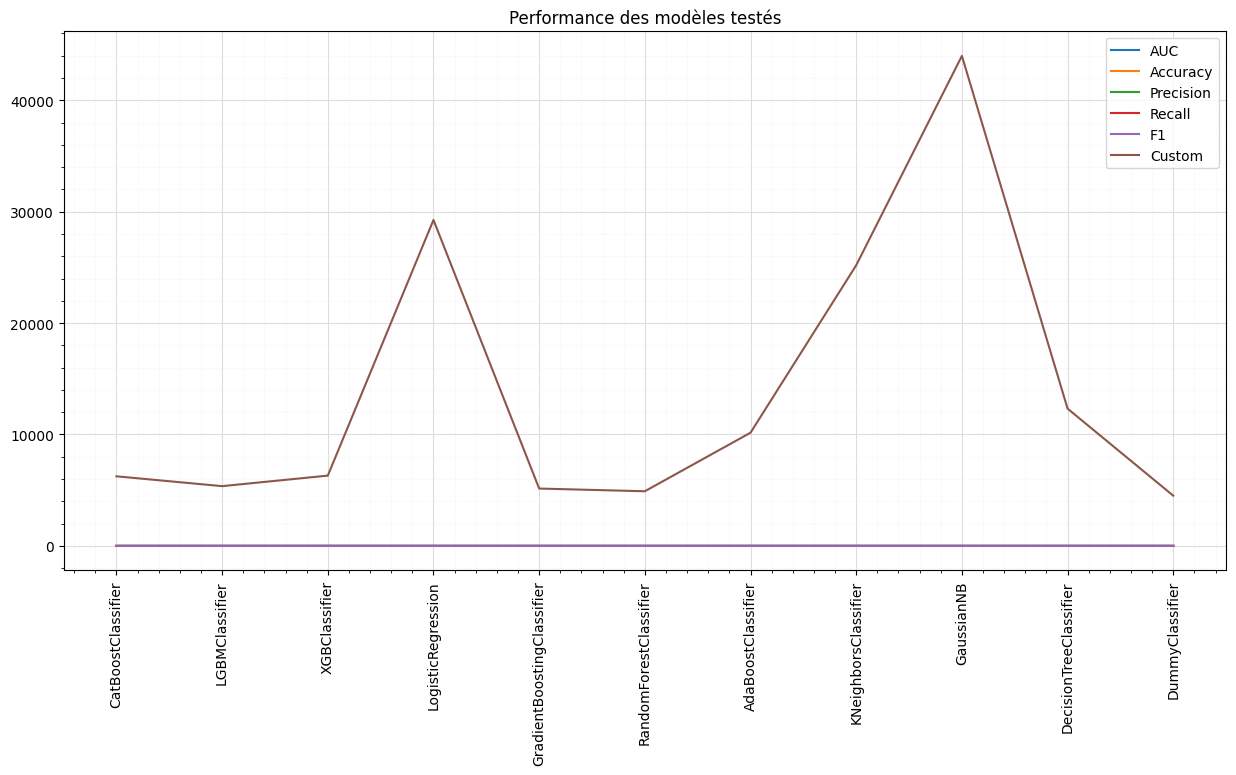

In [53]:
# plot results

plt.figure(figsize = (15, 7))
plt.title('Performance des modèles testés')
for i in base_models.drop(['Model', 'Time'], axis = 1).columns:
    plt.plot(base_models['Model'], base_models[i], label = i)
plt.legend(loc = 'best')
plt.grid(which = 'major', color = '#DDDDDD', linewidth = 0.8)
plt.grid(which = 'minor', color = '#EEEEEE', linestyle = ':', linewidth = 0.5)
plt.minorticks_on()
plt.xticks(rotation = 90)
plt.show()

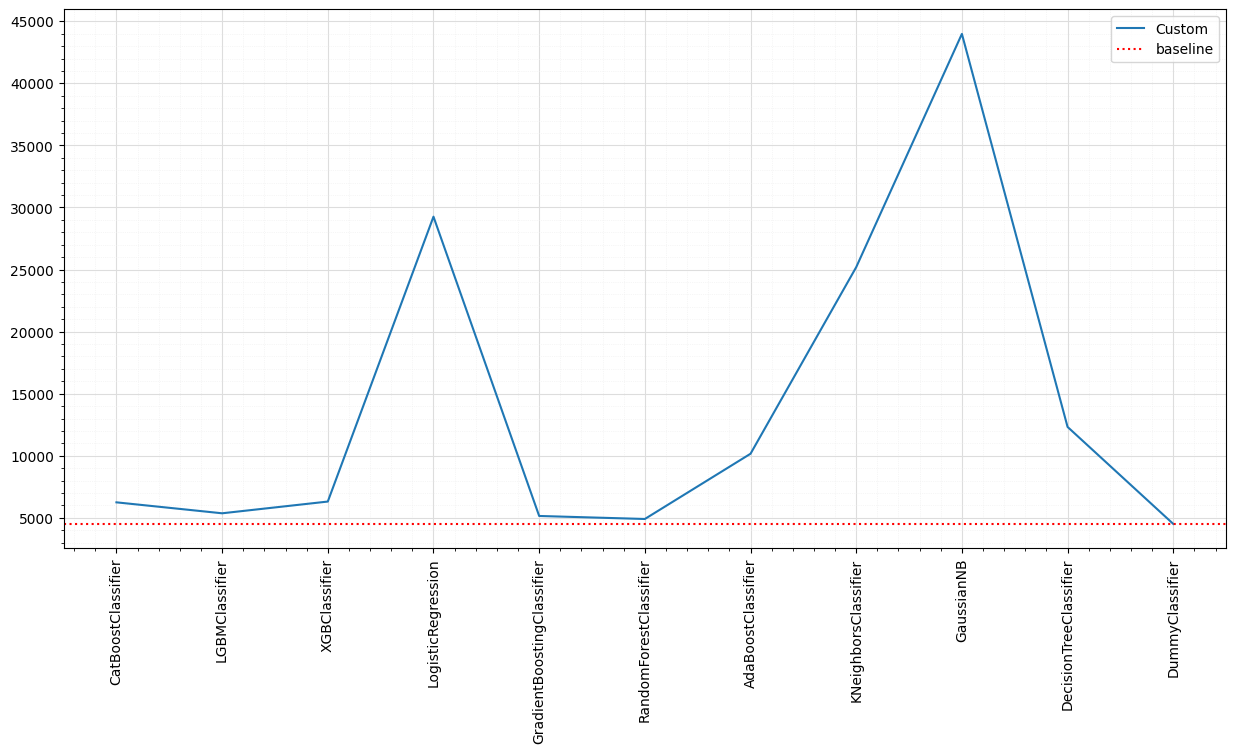

In [54]:
# plot results métrique custom only
base_models_custom = base_models[['Model', 'Custom']]

plt.figure(figsize = (15, 7))
for i in base_models_custom.drop(['Model'], axis = 1).columns:
    plt.plot(base_models_custom['Model'], base_models_custom[i], label = i)
plt.axhline(y = 4509, color = 'r', linestyle = ':', label = 'baseline')
plt.legend(loc = 'best')
plt.grid(which = 'major', color = '#DDDDDD', linewidth = 0.8)
plt.grid(which = 'minor', color = '#EEEEEE', linestyle = ':', linewidth = 0.5)
plt.minorticks_on()
plt.xticks(rotation = 90)
plt.show()

In [55]:
# essayer de trouver solution mais si je galère vraiment trop je laisse tomber
# comparer 3-5 modèles

In [56]:
# voir comment plotter graphs avec différentes échelles
# https://stackoverflow.com/questions/9103166/multiple-axis-in-matplotlib-with-different-scales

In [57]:
# choisir un seul modèle et le fine tuner (eventuellement deux si j'ai un doute)
# ici : doute entre avec et sans smote

# sans smote : GaussianNB : 45936
# avec smote : KNeighborsClassifier : 12385

# fine tuner les 2

In [58]:
# Make scorer
# -> permet de définir dans quel "sens" prendre notre nouvelle métrique (ici, plus la valeur est grande, mieux c'est)
custom_score = make_scorer(cost.custom_metric, greater_is_better = True)
custom_score

make_scorer(custom_metric)

In [59]:
########### Fine tunning - GaussianNB ##############

In [60]:
with mlflow.start_run(run_name = 'Fine tunning'):
    print(type(model).__name__)
    # Instancier le modèle
    gauss = GaussianNB()

    # Entrainer le modèle
    gauss.fit(X_train, y_train)

    # Predire
    y_pred_test_default = gauss.predict(X_test)
    y_pred_train_default = gauss.predict(X_train)

    mlflow.sklearn.log_model(gauss, 'GaussianNB')
    mlflow.log_metric('custom', cost.custom_metric(y_test, model.predict(X_test)))

XGBClassifier


In [61]:
########## GaussianNB Default Params ##########

# Instancier le modèle
gauss = GaussianNB()

# Entrainer le modèle
gauss.fit(X_train, y_train)

# Predire
y_pred_test_default = gauss.predict(X_test)
y_pred_train_default = gauss.predict(X_train)

cost.custom_metric(y_test, model.predict(X_test))

6309

In [62]:
########## GRIDSEARCH CV ##########

# attention, bien mettre le modèle et __ avant nom du paramètre
param_grid = {
    'classification__var_smoothing': np.logspace(0, -9, num = 100) # stability calculation to widen (or smooth) the curve and therefore account for more samples that are further away from the distribution mean
             }

model = Pipeline([('sampling', SMOTE()), ('classification', GaussianNB())])

with mlflow.start_run(run_name = 'Fine tunning'):
    print(type(model).__name__)
    grid = GridSearchCV(
        model,
        param_grid,
        scoring = custom_score,
        cv = 5,
        verbose = 1,
        n_jobs = -1 # use all CPUs
        )

    # On entraîne la grille
    grid.fit(X_train, y_train)

    # Meilleur score obtenu: best_score_
    print(f'\nBest score = {grid.best_score_}')

    # Optimal hyperparameters: best_params_
    display(grid.best_params_)

    # Sauvegarder le meilleur modèle
    best_gauss = grid.best_estimator_

    # Predire
    y_pred_test_best = best_gauss.predict(X_test)
    y_pred_train_best = best_gauss.predict(X_train)

    mlflow.sklearn.log_model(model, 'GaussianNB grid')
    # Log model configuration/params
    mlflow.log_params(grid.best_params_)
    mlflow.log_metric('custom', cost.custom_metric(y_test, best_gauss.predict(X_test)))

Pipeline
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/homebrew/lib/python3.


Best score = 35127.6


{'classification__var_smoothing': 1.0}

Python(74578) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Quantités de données à utiliser pour l'entrainement (10 lots): [ 37254  53812  70369  86927 103485 120042 136600 153157 169715 186273]


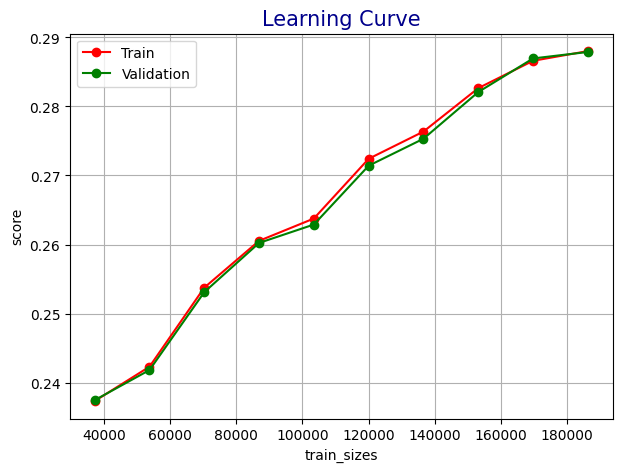

In [63]:
# Courbe d'apprentissage (learning curve)
# montre l'évolution des performances du modèle en fonction de la quantité de données qu'on lui fournit

N, train_score, val_score = learning_curve(best_gauss, X_train, y_train, train_sizes = np.linspace(0.2, 1.0, 10), cv = 5)

# Train sizes
print(f"Quantités de données à utiliser pour l'entrainement (10 lots): {N}")

# Learning curve
plt.figure(figsize = (7,5))
plt.grid()
plt.plot(N, train_score.mean(axis = 1), 'o-', color = 'r', label = 'Train')
plt.plot(N, val_score.mean(axis = 1), 'o-', color  = 'g', label = 'Validation')
plt.title ('Learning Curve', fontsize = 15, color = 'darkblue')
plt.legend(loc = 'best')
plt.xlabel('train_sizes')
plt.ylabel('score')
plt.show()

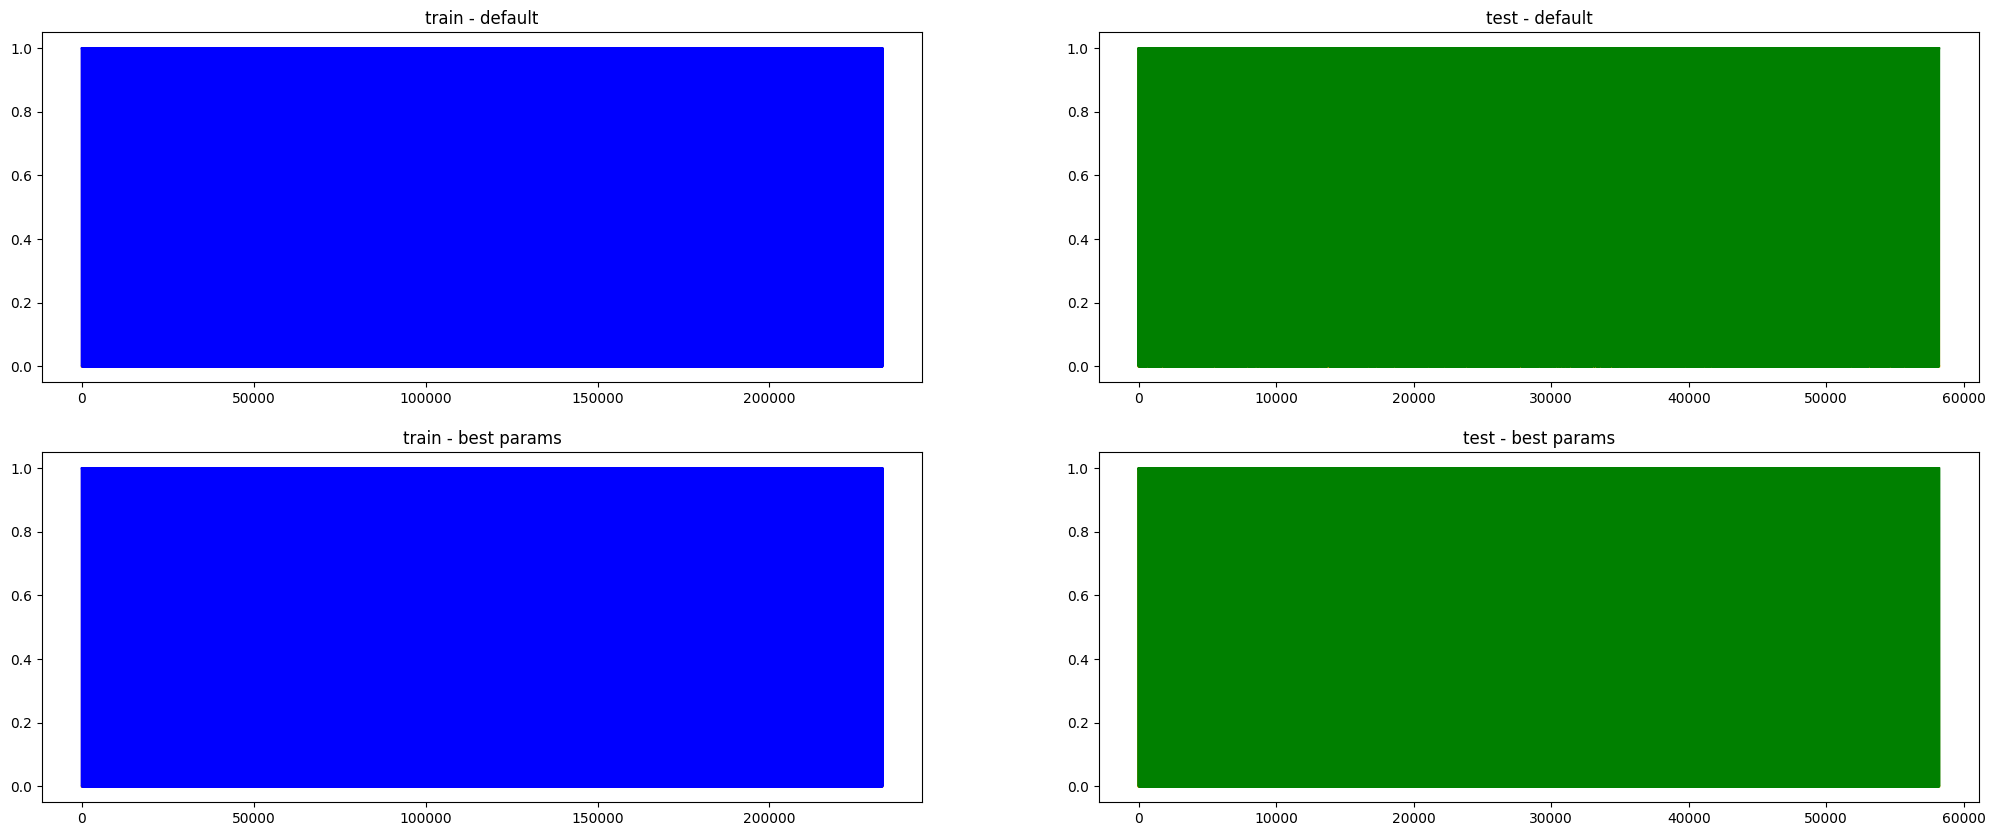

In [64]:
# Plot prédictions

plt.figure(figsize = (25, 10))
plt.subplot(2, 2, 1)
plt.plot(y_train.values, color = 'orange')
plt.plot(y_pred_train_default, color = 'blue')
plt.title('train - default')
plt.subplot(2, 2, 2)
plt.plot(y_test.values, color = 'orange')
plt.plot(y_pred_test_default, color = 'green')
plt.title('test - default')
plt.subplot(2, 2, 3)
plt.plot(y_train.values, color = 'orange')
plt.plot(y_pred_train_best, color = 'blue')
plt.title('train - best params')
plt.subplot(2, 2, 4)
plt.plot(y_test.values, color = 'orange')
plt.plot(y_pred_test_best, color = 'green')
plt.title('test - best params')

plt.show()

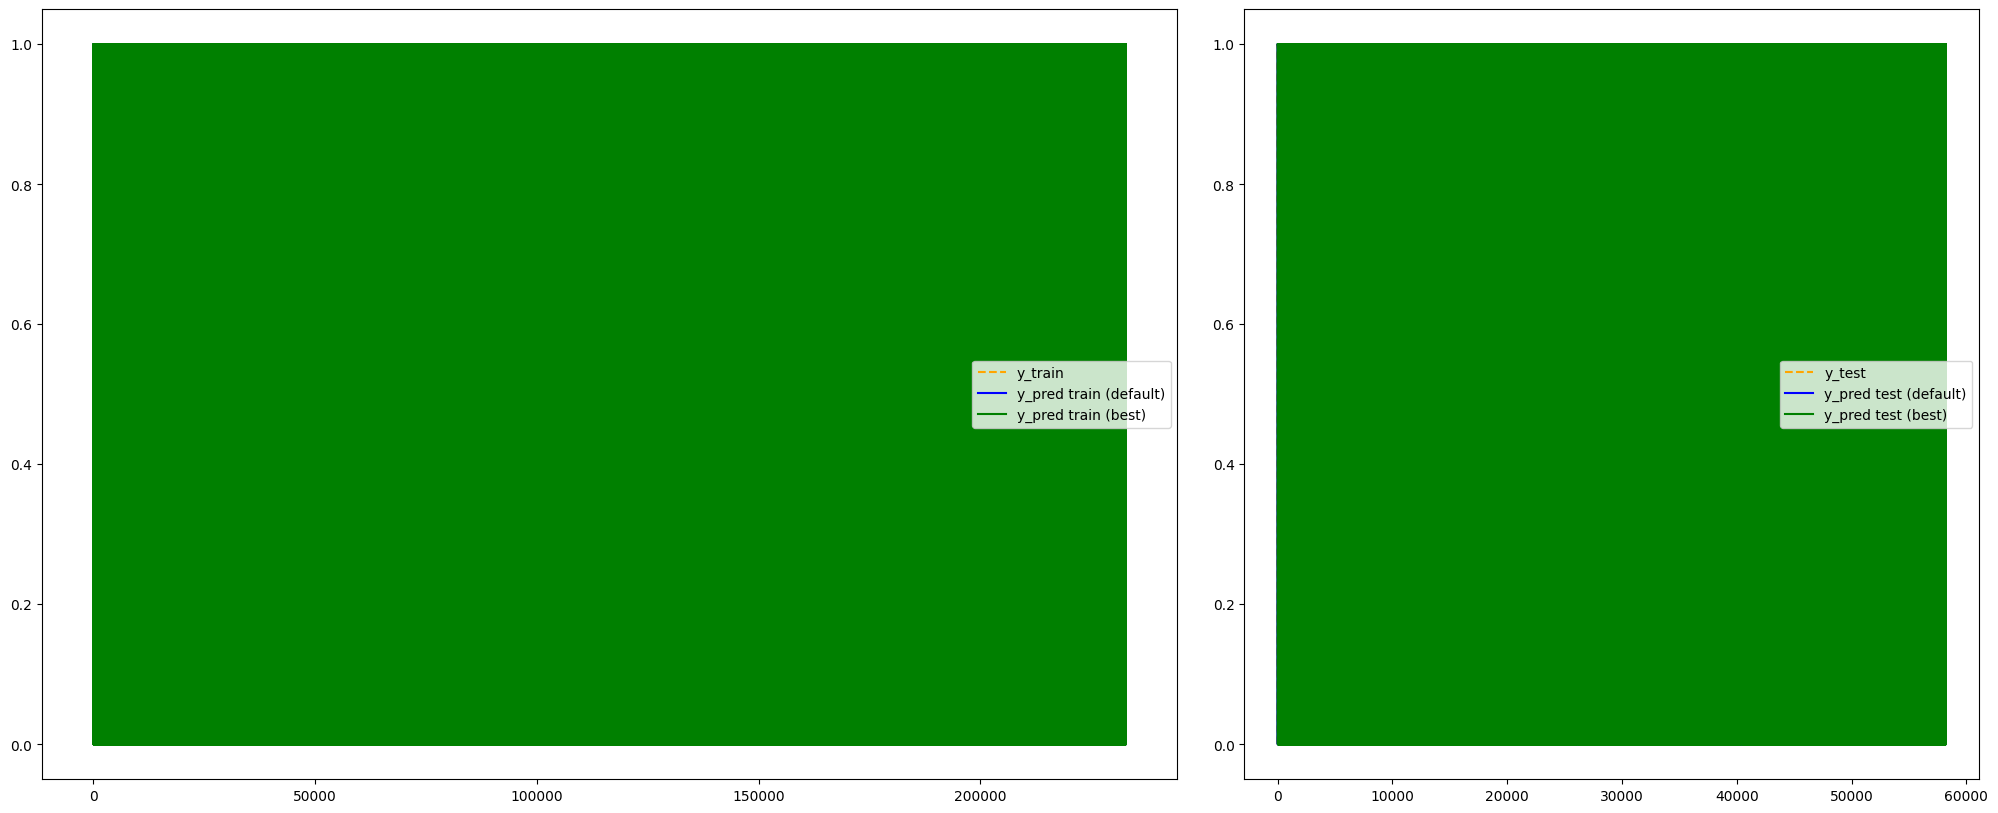

In [65]:
# Plot prédictions

plt.figure(figsize = (25, 10))

ax1 = plt.subplot2grid((1, 5), (0, 0), colspan = 3)
ax1.plot(y_train.values, color = 'orange', linestyle = '--', label = 'y_train')
ax1.plot(y_pred_train_default, color = 'blue', label = 'y_pred train (default)')
ax1.plot(y_pred_train_best, color = 'green', label = 'y_pred train (best)')
plt.legend(loc = "best")

ax2 = plt.subplot2grid((1, 5), (0, 3), colspan = 2)
ax2.plot(y_test.values, color = 'orange', linestyle = '--', label = 'y_test')
ax2.plot(y_pred_test_default, color = 'blue', label = 'y_pred test (default)')
ax2.plot(y_pred_test_best, color = 'green', label = 'y_pred test (best)')
plt.legend(loc = "best")

plt.show()

### Feature importance

In [66]:
# feature importance
# par exemple shap
# certains modèles comme random forest le font direct

# SHAP

# https://www.kaggle.com/code/wrosinski/shap-feature-importance-with-feature-engineering
# https://www.datacamp.com/tutorial/introduction-to-shap-values-machine-learning-interpretability

In [68]:
plt.rcParams['figure.figsize'] = (12, 9)
plt.style.use('ggplot')

#!pip install shap
import shap
shap.initjs()

In [71]:
best_gauss[1]

GaussianNB(var_smoothing=1.0)

In [72]:
explainer = shap.Explainer(best_gauss[1])
shap_values = explainer.shap_values(X_test)

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: GaussianNB(var_smoothing=1.0)

In [75]:
test_gauss = GaussianNB(var_smoothing=1.0)

explainer = shap.KernelExplainer(test_gauss, X_train)
shap_values = explainer.shap_values(X_test)

Provided model function fails when applied to the provided data set.


TypeError: 'GaussianNB' object is not callable

In [ ]:
# https://stackoverflow.com/questions/62933365/how-to-get-the-feature-importance-in-gaussian-naive-bayes

In [76]:
from sklearn.inspection import permutation_importance
imps = permutation_importance(best_gauss, X_test, y_test)
print(imps.importances_mean)

[-4.46650977e-05  0.00000000e+00  1.37431070e-04 -2.06146605e-05
  1.54609953e-04  2.52873168e-03  8.67877205e-03  2.13361736e-03
  1.01698992e-03  1.12006322e-03 -3.09219907e-05  0.00000000e+00
  1.16713336e-02  1.24375118e-03  0.00000000e+00  1.14067788e-03
  1.54609953e-04 -5.84082046e-05  4.20195496e-03  4.35656491e-03
  4.15728986e-04  7.55870884e-05  3.77935442e-05  2.40504372e-05
  4.49399598e-03  1.24546907e-02  7.34569068e-03  2.63180499e-03
  8.37642370e-03  4.93377540e-03  1.82096167e-04  2.74862139e-05
  0.00000000e+00  1.71788837e-05  4.46650977e-05  8.55508409e-04
  6.52797581e-05  6.04696707e-04  1.82096167e-04  6.52797581e-05
  3.09219907e-05  2.47375926e-04 -1.03073302e-05 -6.87155349e-06
  1.78660391e-04  5.49724279e-05  0.00000000e+00  3.43577674e-06
  5.15366511e-05  7.90228651e-04  7.21513116e-05  5.22238065e-04
  2.26761265e-04  5.84082046e-05  6.18439814e-05  2.13018158e-04
 -1.03073302e-05 -1.37431070e-05  2.16453935e-04  2.74862139e-05
  0.00000000e+00  2.06146

In [ ]:
stop

In [84]:
model.steps

[('sampling', SMOTE()), ('classification', GaussianNB())]

In [88]:
model.steps[1][1]

GaussianNB()

In [78]:
########## FEATURES IMPORTANTES ##########
# identifier les features importantes

# get importance
score = model.steps[1][1].feature_importances_
feature = X.columns #(pour ne pas prendre l'index)

# transformer en df pour visualiser plus facilement
df_feature = pd.DataFrame()
df_feature['feature'] = feature
df_feature['score'] = score

df_feature.sort_values(['score'], ascending = False, inplace = True)

# bar plot pour visualiser les 25 features les plus importantes
plt.figure(figsize = (10, 7))
plt.title('Feature importances')
sns.barplot(x = df_feature['feature'].values[:25], y = df_feature['score'].values[:25])
plt.xticks(rotation = 90)
plt.show()

AttributeError: 'GaussianNB' object has no attribute 'feature_importances_'